In [1]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
# https://medium.com/@rahul.vamusani98/implementation-of-rnn-in-text-classification-tasks-172f745a1584
# https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class3/lstm_toxic.py
# https://github.com/jatana-research/Text-Classification/blob/master/RNN.ipynb
from __future__ import print_function, division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
# from sklearn.metrics import roc_auc_score

# For Google Colaboratory
from google.colab import drive
drive.mount('/content/gdrive')

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU


MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 20106
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

# load in pre-trained word vectors
# print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/gdrive/My Drive/projects/spark/neural_net/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
# print('Found %s word vectors.' % len(word2vec))

# prepare text samples and their labels
# print('Loading in comments...')

train = pd.read_csv("/content/gdrive/My Drive/projects/spark/neural_net/preprocessing/preprocessed_data.csv")
sentences = train["case_text"].values
possible_labels = ["misconduct"]
targets = train[possible_labels].values

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# print("max sequence length:", max(len(s) for s in sequences))
# print("min sequence length:", min(len(s) for s in sequences))
# s = sorted(len(s) for s in sequences)
# print("median sequence length:", s[len(s) // 2])

# get word -> integer mapping
word2idx = tokenizer.word_index
# print('Found %s unique tokens.' % len(word2idx))

# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# print('Shape of data tensor:', data.shape)

# prepare embedding matrix
# print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector
          
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

# print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

loss = []
val_loss = []

accs = []
val_accs = []


for train_index, test_index in skf.split(data, targets):
#     print('Training model...')
    r = model.fit(
      data[train_index],
      targets[train_index],
      validation_data=(data[test_index], targets[test_index])
    )
    
    # save loss and validation loss
    loss.append(r.history['loss'])
    val_loss.append(r.history['val_loss'])
    
    # save accuracy and validation accuracy
    accs.append(r.history['acc'])
    val_accs.append(r.history['val_acc'])

Train on 498 samples, validate on 126 samples
Epoch 1/1
498/498 [==============================] - 309s 620ms/step - loss: 0.6270 - acc: 0.6606 - val_loss: 0.5548 - val_acc: 0.7460
Train on 498 samples, validate on 126 samples
Epoch 1/1
498/498 [==============================] - 305s 613ms/step - loss: 0.5221 - acc: 0.7510 - val_loss: 0.5319 - val_acc: 0.7460
Train on 500 samples, validate on 124 samples
Epoch 1/1
500/500 [==============================] - 304s 609ms/step - loss: 0.4958 - acc: 0.7600 - val_loss: 0.4953 - val_acc: 0.7661
Train on 500 samples, validate on 124 samples
Epoch 1/1
500/500 [==============================] - 304s 608ms/step - loss: 0.4714 - acc: 0.7660 - val_loss: 0.3987 - val_acc: 0.7903
Train on 500 samples, validate on 124 samples
Epoch 1/1
500/500 [==============================] - 304s 609ms/step - loss: 0.4430 - acc: 0.8080 - val_loss: 0.3940 - val_acc: 0.7903


In [3]:
# print average validation accuracy
print(np.mean(val_accs))

0.767767538092897


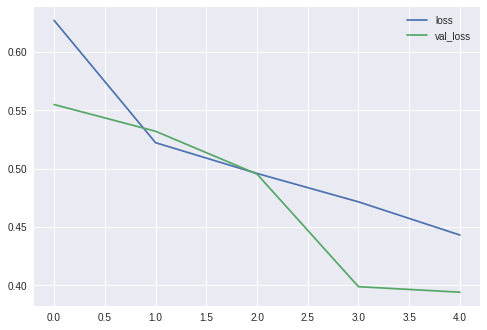

In [4]:
# plot loss function
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

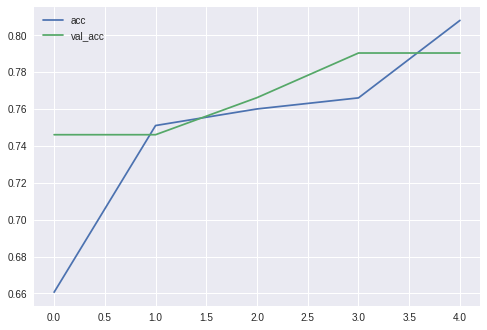

In [5]:
# plot accuracies
plt.plot(accs, label='acc')
plt.plot(val_accs, label='val_acc')
plt.legend()
plt.show()

In [6]:
# display summary of neural net
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20106)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20106, 50)         1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20106, 30)         7920      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 1,007,951
Trainable params: 7,951
Non-trainable params: 1,000,000
_________________________________________________________________


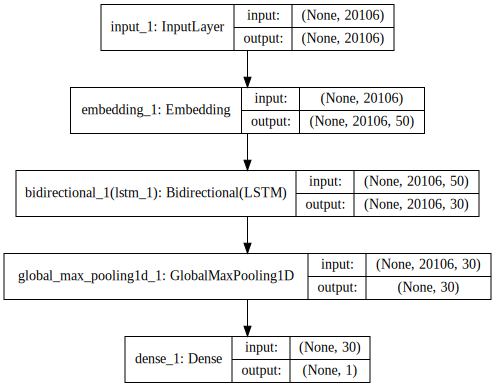

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# display design of neural net
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))